# Required libraries

In [ ]:
# !pip install transformers
# !pip install langdetect
!pip install clean-text
!pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 5.3 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171033 sha256=a742841c75ba276e10f07729661ccd4f28397670882772d0884ffb5af3d3de2f
  Stored in directory: /root/.cache/pip/wheels/31/8a/8c/315c9e5d7773f74b33d5ed33f075b49c6eaeb7cedbb86e2cf8
Successfully built emoji
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 5.0 MB/s eta 0:00:00


In [ ]:
# from google.colab import drive
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
# from transformers import pipeline
import re
import unidecode
import heapq
from textblob import TextBlob
import warnings
from cleantext import clean
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC



nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
warnings.filterwarnings("ignore")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Dataset

## Load dataset

In [ ]:
# drive.mount('/content/drive')

In [ ]:
# %%time
# df = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Amazon_Unlocked_Mobile.csv')

url = "https://media.githubusercontent.com/media/SrtSaa/Amazon_Mobile_Dataset/main/Amazon_Unlocked_Mobile.csv"
df = pd.read_csv(url, encoding='unicode_escape')

## Information of dataset

In [ ]:
df.columns

Index(['Product Name', 'Brand Name', 'Price', 'Rating', 'Reviews',
       'Review Votes'],
      dtype='object')

In [ ]:
df

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0
...,...,...,...,...,...,...
413835,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,5,another great deal great price,0.0
413836,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,3,Ok,0.0
413837,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,5,Passes every drop test onto porcelain tile!,0.0
413838,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,3,I returned it because it did not meet my needs...,0.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413840 entries, 0 to 413839
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Product Name  413840 non-null  object 
 1   Brand Name    348669 non-null  object 
 2   Price         407907 non-null  float64
 3   Rating        413840 non-null  int64  
 4   Reviews       413778 non-null  object 
 5   Review Votes  401544 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 18.9+ MB


# Dataset cleaning

*   delete unused column
*   delete consecutive duplicate rows
*   delete punctuation, emoji, url, email, number and fix unicode
*   remove stopwords
*   convert string data into lower case



In [ ]:
# drop 'Review Votes' as it is not important so much
df.drop(['Review Votes','Price'], axis = 1, inplace=True)
df.shape

(413840, 4)

In [ ]:
df.isna().sum()     # empty cell information

Product Name        0
Brand Name      65171
Rating              0
Reviews            62
dtype: int64

In [ ]:
%%time
# collect valid available brand name and index of invalid brand name
avail_brand = set()
for i in range(df.shape[0]):
    try:
        if i%25000 == 0:
            print(i)
        df['Brand Name'][i] = df['Brand Name'][i].lower()
        avail_brand.add(df['Brand Name'][i])
    except Exception as e:
        pass
# avail_brand

0
25000
50000
75000
100000
125000
150000
175000
200000
225000
250000
275000
300000
325000
350000
375000
400000
CPU times: user 14min 18s, sys: 6.54 s, total: 14min 24s
Wall time: 15min 28s


In [ ]:
# set of product name where brand name is not available
noBrand_product_set = set(df[df['Brand Name'].isna()]['Product Name'])
# noBrand_product_set
# list of indices where brand name is not present
absentIndexList = df[df['Brand Name'].isna()]['Product Name'].index.tolist()

In [ ]:
# extract the brand name from the product name
shorted_set = set()
for k in noBrand_product_set:
    try:
        s = clean(k.split()[0], no_emoji=True, no_digits=True, replace_with_digit='')
        shorted_set.add(s)
    except Exception as e:
        pass
# len(shorted_set)

matched_set = avail_
brand.intersection(shorted_set)
# len(matched_set)

In [ ]:
# put most common brand name in blank areas
for ind in absentIndexList:
    s = df['Product Name'][ind]
    s = clean(s.split()[0], no_emoji=True, no_digits=True, replace_with_digit='')
    if s in matched_set:
        df['Brand Name'][ind] = s

In [ ]:
# no of cells having empty brand name
df['Brand Name'].isna().sum()

7243

In [ ]:
# delete empty cells
x = sum(df.isna().sum())
df.dropna(inplace = True)       # delete the rows containing empty cell
df.reset_index(inplace=True, drop=True)    # reset indices

print(x, "row(s) deleted")
df.shape

7305 row(s) deleted


(406535, 4)

In [ ]:
# corrctify the brand names
name_dict = {
    'amazon': 'amazon.com, llc *** keep porules active ***',
    'bluecosmo': 'aeroantenna',
    'asus': 'asus computers',
    'cat': 'cat phones',
    'conquest': 'conquest s8 pro 3gb smartphone (black)',
    'cubot': 'china',
    'glocalme': 'glocalme®',
    'google': 'google pixel',
    'homtom': 'homtom ht7',
    'hp': 'hp handheld',
    'htc': 'htc america',
    'indigi': 'indigi®',
    'ipro': 'ipro group',
    "john's": "john's phone",
    'ofeely': 'ofeely company',
    'plum': 'plum mobile',
    'wogiz': 'q',
    'sonim': 'sonim technologies',
    'utstarcom': 'ut starcom',
    'worryfree': 'worryfree gadgets',
    'yezz': 'yezz wireless ltd.',
    'otterbox': 'defender',
    'elephone': 'ecoo',
    'sanyo': ['sanyo, katana','el guapo'],
    'doogee': ['diko','kvd'],
    'lenovo': ['lenovo manufacturer','dk'],
    'apple': ['apple computer','certified refurbished'],
    'zte': ['zte corporation','zte(usa) wireless','dead sea secrets'],
    'blackberry': ['black berry', 'blackberrry', 'blackberry (rim)', 'blackberry storm 9530 smartphone unlocked gsm wireless handheld device w/camera bluetooth 3.25" touchscreen lcd','rim'],
    'fosler': ['fosler company', 'fosler corporation'],
    'nokia': ['selected-gadgets', 'the nokia','at&t'],
    'lg': ['lg electronic', 'lg electronics','lg electronics mobilecomm usa','wireless one'],
    'motorola': ['moto x', 'motorola x 2nd gen xt1093','shoptech4less'],
    'samsung': ['galaxy','red','s7 active,''samssung','samsung galaxy','samsung galaxy international inc','samsung international','samsung korea','samsung korea ltd','samsung/straight talk','samsybg galaxy',],
    'shenzhen': ['shenzhen jinwanyi company','shenzhen snopow outdoor technology co.,ltd','shenzhen snopow outdoor technology co.ltd','shenzhen xin sheng shang technology co.,ltd'],
    'sony': ['sony ericsson','sony ericsson mobile','sony/ericsson','sonyericsson'],
}

for k in name_dict:
    df['Brand Name'].replace(name_dict[k],k, inplace=True)

In [ ]:
len(set(df['Brand Name']))

268

In [ ]:
# finding the consecutive duplicate rows and delete it
l = []

for i in range(df.shape[0]-1):
    if df['Product Name'][i] == df['Product Name'][i+1] and df['Brand Name'][i] == df['Brand Name'][i+1] and \
        df['Rating'][i] == df['Rating'][i+1] and df['Reviews'][i] == df['Reviews'][i+1]:
        l.append(i)

df.drop(l, axis=0, inplace=True)

df.reset_index(inplace=True, drop=True)    # reset indices
print(len(l), "row(s) deleted")
df.shape

514 row(s) deleted


(406021, 4)

In [ ]:
# set of stopwords
stop_words = set(stopwords.words('english'))

# function to delete punctuation, emoji, url, email, number, stopwords, and fix unicode
def clear(s):
    # remove punctuation, emoji, url, email, number, and fix unicode
    s = clean(s, no_punct=True, no_emoji=True, no_urls=True, no_emails=True, no_digits=True, fix_unicode=True,
              replace_with_punct="", replace_with_url="", replace_with_email="", replace_with_digit="")

    # remove more punctuation
    s = s.translate(str.maketrans('', '', string.punctuation))

    # remove stopwords
    s = " ".join([word for word in str(s).split() if word not in stop_words])

    return s

In [ ]:
# delete punctuation, emoji, url, email, number, stopwords, and fix unicode
df['Reviews'] = df['Reviews'].apply(clear)

In [ ]:
# delete the rows where length of the review is less than 2
l = []
for i in range(df.shape[0]):
    if len(df['Reviews'][i]) <2:
        l.append(i)

df.drop(l, axis=0, inplace=True)

df.reset_index(inplace=True, drop=True)    # reset indices
print(len(l), "row(s) deleted")
df.shape

1194 row(s) deleted


(404827, 4)

In [ ]:
# put the tag for available rating
def putTag(d):
    tag = []
    ref = {1: "Highly Negative", 2:"Negative",
            3: "Neutral", 4: "Positive", 5:"Highly Positive"}
    for i in d["Rating"]:
        tag.append(ref[i])
    return tag

df['Manual Tag'] = putTag(df)
df = df[["Product Name", "Brand Name", "Reviews", "Rating", "Manual Tag"]]

In [ ]:
df

,Product Name,Brand Name,Reviews,Rating,Manual Tag
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",samsung,feel lucky found used phone us used hard phone...,5,Highly Positive
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",samsung,nice phone nice grade pantach revue clean set ...,4,Positive
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",samsung,pleased,5,Highly Positive
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",samsung,works good goes slow sometimes good phone love,4,Positive
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",samsung,great phone replace lost phone thing volume bu...,4,Positive
...,...,...,...,...,...
404822,Samsung Convoy U640 Phone for Verizon Wireless...,samsung,another great deal great price,5,Highly Positive
404823,Samsung Convoy U640 Phone for Verizon Wireless...,samsung,ok,3,Neutral
404824,Samsung Convoy U640 Phone for Verizon Wireless...,samsung,passes every drop test onto porcelain tile,5,Highly Positive
404825,Samsung Convoy U640 Phone for Verizon Wireless...,samsung,returned meet needs seemed good selection others,3,Neutral


# VADER preprocessing

In [ ]:
# apply vader preprocessing
def sentiment_scores(sentences):
	sid_obj = SentimentIntensityAnalyzer()
	rating, tag = [], []

	for i in range(len(sentences)):
		try:
			sentiment_dict = sid_obj.polarity_scores(sentences[i])
		except AttributeError:
			print(sentences[i],i)

		if sentiment_dict['compound'] >= 0.6:
			rating.append(5)
			tag.append("Highly Positive")
		elif sentiment_dict['compound'] >= 0.2:
			rating.append(4)
			tag.append("Positive")
		elif sentiment_dict['compound'] <= -0.6:
			rating.append(1)
			tag.append("Highly Negative")
		elif sentiment_dict['compound'] <= -0.2:
			rating.append(2)
			tag.append("Negative")
		else:
			rating.append(3)
			tag.append("Neutral")

	return rating, tag

In [ ]:
df_vader = df.copy()
df_vader['Vader Rating'], df_vader['Vader Tag'] = sentiment_scores(df_vader['Reviews'].copy())
df_vader.head()

,Product Name,Brand Name,Reviews,Rating,Manual Tag,Vader Rating,Vader Tag
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",samsung,feel lucky found used phone us used hard phone...,5,Highly Positive,5,Highly Positive
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",samsung,nice phone nice grade pantach revue clean set ...,4,Positive,5,Highly Positive
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",samsung,pleased,5,Highly Positive,4,Positive
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",samsung,works good goes slow sometimes good phone love,4,Positive,5,Highly Positive
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",samsung,great phone replace lost phone thing volume bu...,4,Positive,4,Positive


In [ ]:
# df_vader.drop(df_vader[abs(df_vader['Rating'] - df_vader['Vader Rating']) > 1].index, inplace=True)
# df_vader.reset_index(inplace=True, drop=True)
# print(df.shape[0] - df_vader.shape[0],"row(s) deleted")
# df_vader.shape

In [ ]:
# extract some specific columns
# res = df_vader.drop('Price', axis=1)
res = df_vader.drop(['Brand Name','Rating','Vader Rating'], axis=1)
res.head()

,Product Name,Reviews,Manual Tag,Vader Tag
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",feel lucky found used phone us used hard phone...,Highly Positive,Highly Positive
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",nice phone nice grade pantach revue clean set ...,Positive,Highly Positive
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",pleased,Highly Positive,Positive
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",works good goes slow sometimes good phone love,Positive,Highly Positive
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",great phone replace lost phone thing volume bu...,Positive,Positive


In [ ]:
d1 = res['Manual Tag'].value_counts()
d2 = res['Vader Tag'].value_counts()
data1 = pd.DataFrame([d1, d2]).T
data1.columns = ['manual','vader']
data1

,manual,vader
Highly Positive,218702,180944
Highly Negative,70771,15809
Positive,60071,102728
Neutral,31094,73267
Negative,24189,32079


## Graphs

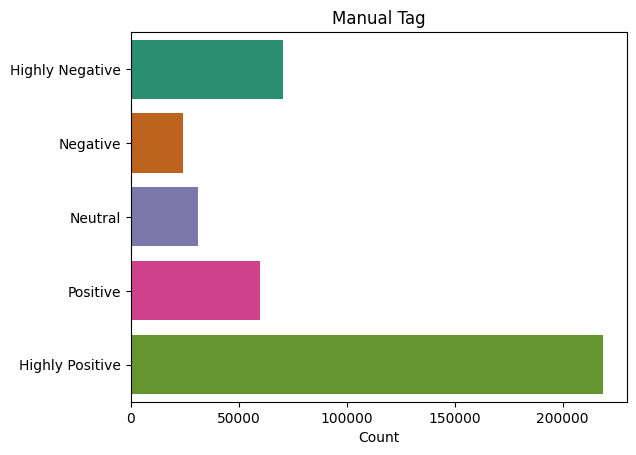

In [ ]:
label = ['Highly Negative', 'Negative', 'Neutral', 'Positive', 'Highly Positive']
count = [data1['manual'][x] for x in label]

sns.barplot(x = count, y = label, palette = 'Dark2')
plt.title('Manual Tag')
plt.xlabel('Count')
plt.show()

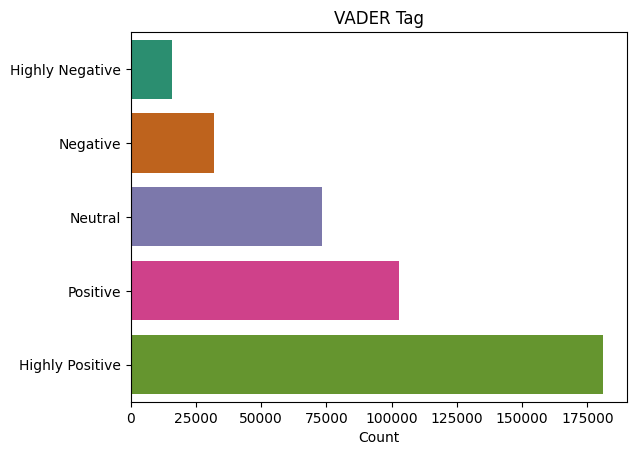

In [ ]:
label = ['Highly Negative', 'Negative', 'Neutral', 'Positive', 'Highly Positive']
count = [data1['vader'][x] for x in label]

sns.barplot(x = count, y = label, palette = 'Dark2')
plt.title('VADER Tag')
plt.xlabel('Count')
plt.show()

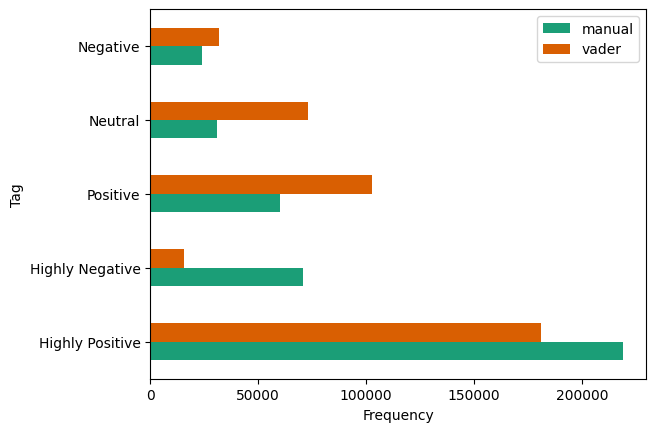

In [ ]:
data1.plot.barh(color=sns.palettes.mpl_palette('Dark2'))
plt.xlabel('Frequency')
plt.ylabel('Tag')
plt.show()

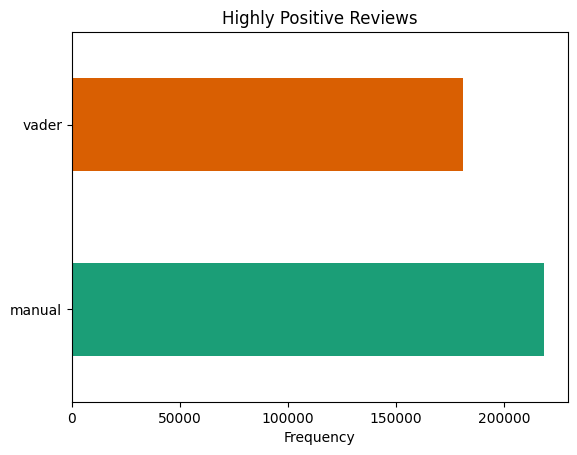

In [ ]:
data1.iloc[0].plot.barh(color=sns.palettes.mpl_palette('Dark2'))
plt.xlabel('Frequency')
plt.title('Highly Positive Reviews')
plt.show()

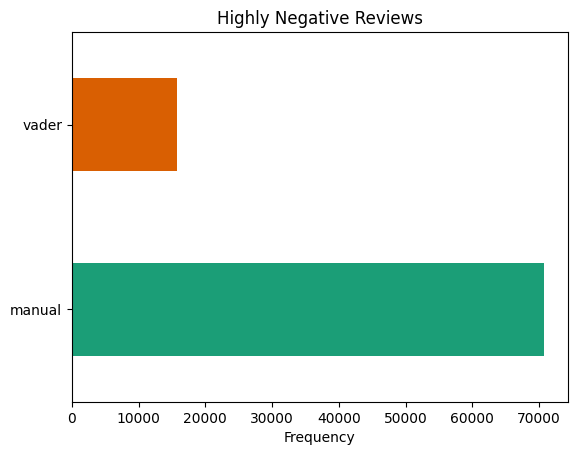

In [ ]:
data1.iloc[1].plot.barh(color=sns.palettes.mpl_palette('Dark2'))
plt.xlabel('Frequency')
plt.title('Highly Negative Reviews')
plt.show()

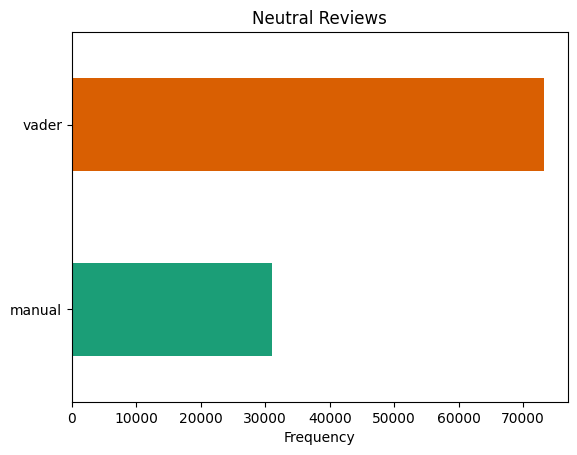

In [ ]:
data1.iloc[3].plot.barh(color=sns.palettes.mpl_palette('Dark2'))
plt.xlabel('Frequency')
plt.title('Neutral Reviews')
plt.show()

# Classifier

In [ ]:
temp = res.copy()

cv = CountVectorizer()
X = cv.fit_transform(temp['Reviews'], temp['Product Name'])


le = LabelEncoder()
temp['Manual Tag'] = le.fit_transform(res['Manual Tag'])
temp['Vader Tag'] = le.fit_transform(res['Vader Tag'])

tagType = ['Manual Tag', 'Vader Tag']
y = temp[['Manual Tag', 'Vader Tag']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

## Naive Bayes

In [ ]:
%%time
# applying naive bias classifier
naiveModel = ComplementNB()
naiveAccScore = ["Naive Bayes"]

for tag in tagType:
    # y = temp['Rating']
    naiveModel.fit(X_train, y_train[[tag]])
    y_pred = naiveModel.predict(X_test)

    print("Classification report:")
    print(classification_report(y_test[[tag]], y_pred))
    print("Accuracy Score for", tag, ": %.2f" % accuracy_score(y_test[[tag]], y_pred))
    print("precision, recall, f1-score:")
    print(precision_recall_fscore_support(y_test[[tag]], y_pred))
    print("confusion_matrix:")
    print(confusion_matrix(y_test[[tag]], y_pred))

    naiveAccScore.append(round(accuracy_score(y_test[[tag]], y_pred), 2))

Classification report:
              precision    recall  f1-score   support

           0       0.60      0.91      0.72     28584
           1       0.80      0.92      0.86     87370
           2       0.59      0.17      0.27      9703
           3       0.55      0.25      0.34     12333
           4       0.53      0.22      0.31     23941

    accuracy                           0.72    161931
   macro avg       0.61      0.49      0.50    161931
weighted avg       0.69      0.72      0.68    161931

Accuracy Score for Manual Tag : 0.72
precision, recall, f1-score:
(array([0.6030923 , 0.8007365 , 0.58909853, 0.55139514, 0.52537641]), array([0.90746572, 0.92084239, 0.17376069, 0.24835806, 0.2200827 ]), array([0.72461379, 0.85659986, 0.2683645 , 0.34246422, 0.3102149 ]), array([28584, 87370,  9703, 12333, 23941]))
confusion_matrix:
[[25939  1417   270   346   612]
 [ 3562 80454   389   931  2034]
 [ 5883  1018  1686   448   668]
 [ 4506  3037   281  3063  1446]
 [ 3120 14549   236 

## Decision Tree

In [ ]:
%%time
# applying decision tree
decTreeModel = DecisionTreeClassifier()
decTreeAccScore = ["Decision Tree"]

for tag in tagType:
    decTreeModel.fit(X_train, y_train[[tag]])
    y_pred = decTreeModel.predict(X_test)

    print("Classification report")
    print(classification_report(y_test[[tag]], y_pred))
    print("Accuracy Score for", tag, ": %.2f" % accuracy_score(y_test[[tag]], y_pred))
    decTreeAccScore.append(round(accuracy_score(y_test[[tag]], y_pred), 2))

Classification report
              precision    recall  f1-score   support

           0       0.82      0.85      0.83     28195
           1       0.87      0.93      0.90     87301
           2       0.74      0.65      0.69      9818
           3       0.71      0.63      0.67     12397
           4       0.72      0.59      0.65     24220

    accuracy                           0.82    161931
   macro avg       0.77      0.73      0.75    161931
weighted avg       0.82      0.82      0.82    161931

Accuracy Score for Manual Tag : 0.82
Classification report
              precision    recall  f1-score   support

           0       0.81      0.74      0.78      6261
           1       0.95      0.95      0.95     72382
           2       0.82      0.84      0.83     12828
           3       0.93      0.92      0.92     29482
           4       0.90      0.91      0.91     40978

    accuracy                           0.92    161931
   macro avg       0.88      0.87      0.88    161

## Random Forest

In [ ]:
%%time
# applying Random Forest classifier
RanForModel = RandomForestClassifier()
RanForAccScore = ["Random Forest"]

for tag in tagType:
    RanForModel.fit(X_train, y_train[[tag]])
    y_pred = RanForModel.predict(X_test)

    print("Classification report")
    print(classification_report(y_test[[tag]], y_pred))
    print("Accuracy Score for", tag, ": %.2f" % accuracy_score(y_test[[tag]], y_pred))
    RanForAccScore.append(round(accuracy_score(y_test[[tag]], y_pred), 2))

Classification report
              precision    recall  f1-score   support

           0       0.82      0.93      0.87     28195
           1       0.84      0.98      0.91     87301
           2       0.96      0.61      0.74      9818
           3       0.93      0.59      0.73     12397
           4       0.92      0.54      0.68     24220

    accuracy                           0.85    161931
   macro avg       0.89      0.73      0.79    161931
weighted avg       0.86      0.85      0.84    161931

Accuracy Score for Manual Tag : 0.85
Classification report
              precision    recall  f1-score   support

           0       0.99      0.65      0.78      6261
           1       0.90      0.98      0.94     72382
           2       0.89      0.76      0.82     12828
           3       0.90      0.91      0.90     29482
           4       0.95      0.87      0.91     40978

    accuracy                           0.91    161931
   macro avg       0.92      0.84      0.87    161

## Support Vector Machine (SVM)

In [ ]:
%%time
# applying SVM classifier
svmModel = SVC()
svmAccScore = ["SVM"]

for tag in tagType:
    svmModel.fit(X_train, y_train[[tag]])
    y_pred = svmModel.predict(X_test)

    # print("Classification report")
    # print(classification_report(y_test, y_pred))
    print("Accuracy Score for", tag, ": %.2f" % accuracy_score(y_test[[tag]], y_pred))
    svmAccScore.append(round(accuracy_score(y_test[[tag]], y_pred), 2))

## K Nearest Neighbors (KNN)

In [ ]:
%%time
# applying KNN classifier
knnModel = KNeighborsClassifier(n_neighbors=6)
knnAccScore = ["KNN"]

for tag in tagType:
    knnModel.fit(X_train, y_train[[tag]])
    y_pred = knnModel.predict(X_test)

    print("Classification report")
    print(classification_report(y_test[[tag]], y_pred))
    print("Accuracy Score for", tag, ": %.2f" % accuracy_score(y_test[[tag]], y_pred))
    knnAccScore.append(round(accuracy_score(y_test[[tag]], y_pred), 2))

## Logistic Regression

In [ ]:
%%time
# applying Logistic Regression classifier
logRegModel = LogisticRegression(max_iter=1000)
logRegAccScore = ["Logistic Regression"]

for tag in tagType:
    logRegModel.fit(X_train, y_train[[tag]])
    y_pred = logRegModel.predict(X_test)

    print("Classification report")
    print(classification_report(y_test[[tag]], y_pred))
    print("Accuracy Score for", tag, ": %.2f" % accuracy_score(y_test[[tag]], y_pred))
    logRegAccScore.append(round(accuracy_score(y_test[[tag]], y_pred), 2))

Accuracy Score for Manual Tag : 0.77
Accuracy Score for Vader Tag : 0.89
CPU times: user 6min 31s, sys: 4min 54s, total: 11min 26s
Wall time: 6min 28s


Backup Model to run faster

In [ ]:
!pip install snapml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 23.1 MB/s eta 0:00:00


In [ ]:
%%time
# applying Logistic Regression classifier
from snapml import LogisticRegression as LgReg
logRegModel = LgReg()
logRegAccScore2 = ["Logistic Regression2"]

for tag in tagType:
    logRegModel.fit(X_train, y_train[[tag]])
    y_pred = logRegModel.predict(X_test)

    # print("Classification report")
    # print(classification_report(y_test, y_pred))
    print("Accuracy Score for", tag, ": %.2f" % accuracy_score(y_test[[tag]], y_pred))
    logRegAccScore.append(round(accuracy_score(y_test[[tag]], y_pred), 2))

Accuracy Score for Manual Tag : 0.76
Accuracy Score for Vader Tag : 0.79
CPU times: user 46.8 s, sys: 263 ms, total: 47.1 s
Wall time: 47.4 s


## Compare Results

In [ ]:
# Collected data
naiveAccScore = ["Naive Bayes", 0.72, 0.69]
decTreeAccScore = ["Decision Tree", 0.83, 0.92]
RanForAccScore = ["Random Forest", 0.85, 0.91]
knnAccScore = ["KNN", 0.73, 0.79]
logRegAccScore = ["Logistic Regression", 0.77, 0.89]


data = [naiveAccScore, decTreeAccScore, RanForAccScore, knnAccScore, logRegAccScore]
acc_comp = pd.DataFrame(data, columns = ['Classifier', 'Manual Tagging', 'Vader Tagging'])

acc_comp

,Classifier,Manual Tagging,Vader Tagging
0,Naive Bayes,0.72,0.69
1,Decision Tree,0.83,0.92
2,Random Forest,0.85,0.91
3,KNN,0.73,0.79
4,Logistic Regression,0.77,0.89


## graphs

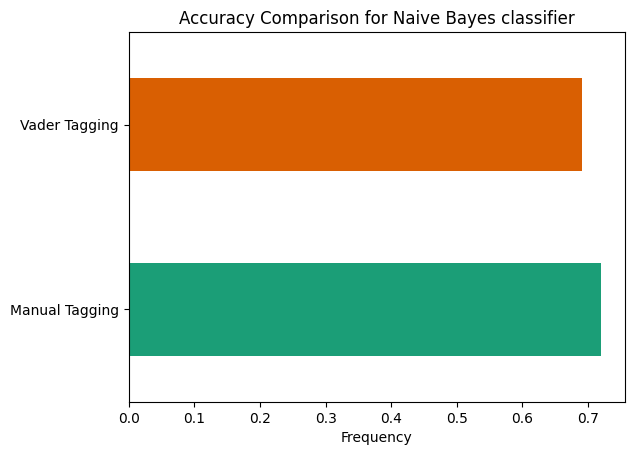

In [ ]:
acc_comp.iloc[0][1:].plot.barh(color=sns.palettes.mpl_palette('Dark2'))
plt.xlabel('Frequency')
plt.title('Accuracy Comparison for {} classifier'.format(acc_comp.iloc[0][0]))
plt.show()

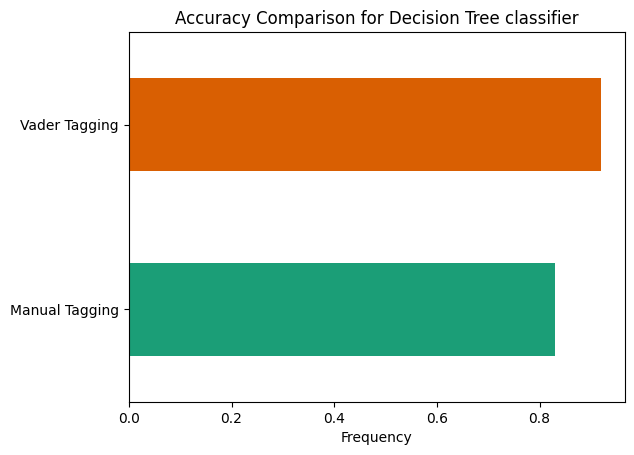

In [ ]:
acc_comp.iloc[1][1:].plot.barh(color=sns.palettes.mpl_palette('Dark2'))
plt.xlabel('Frequency')
plt.title('Accuracy Comparison for {} classifier'.format(acc_comp.iloc[1][0]))
plt.show()

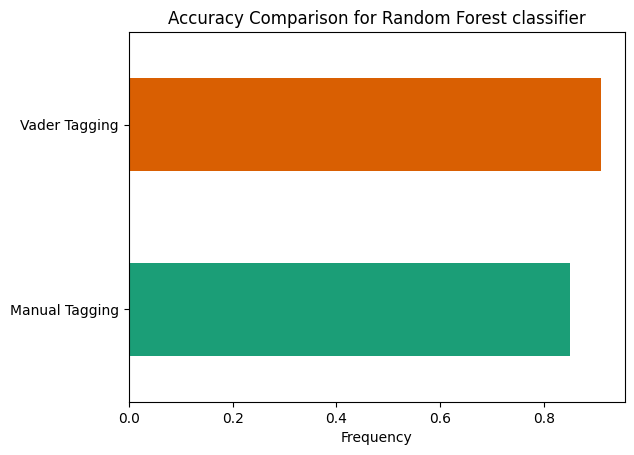

In [ ]:
acc_comp.iloc[2][1:].plot.barh(color=sns.palettes.mpl_palette('Dark2'))
plt.xlabel('Frequency')
plt.title('Accuracy Comparison for {} classifier'.format(acc_comp.iloc[2][0]))
plt.show()

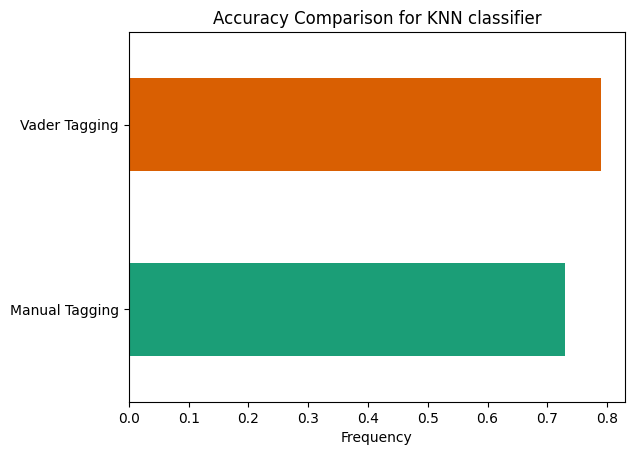

In [ ]:
acc_comp.iloc[3][1:].plot.barh(color=sns.palettes.mpl_palette('Dark2'))
plt.xlabel('Frequency')
plt.title('Accuracy Comparison for {} classifier'.format(acc_comp.iloc[3][0]))
plt.show()

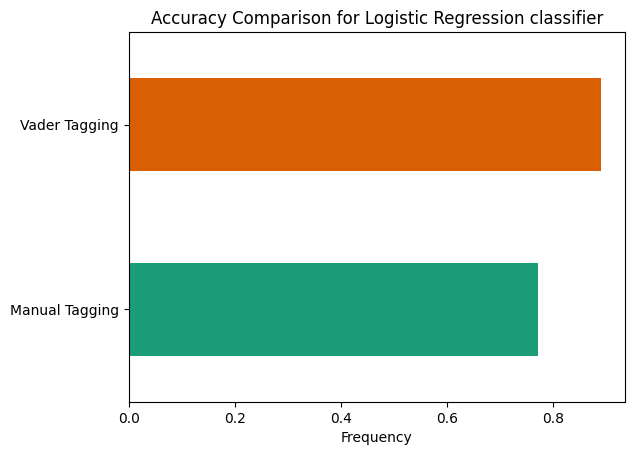

In [ ]:
acc_comp.iloc[4][1:].plot.barh(color=sns.palettes.mpl_palette('Dark2'))
plt.xlabel('Frequency')
plt.title('Accuracy Comparison for {} classifier'.format(acc_comp.iloc[4][0]))
plt.show()

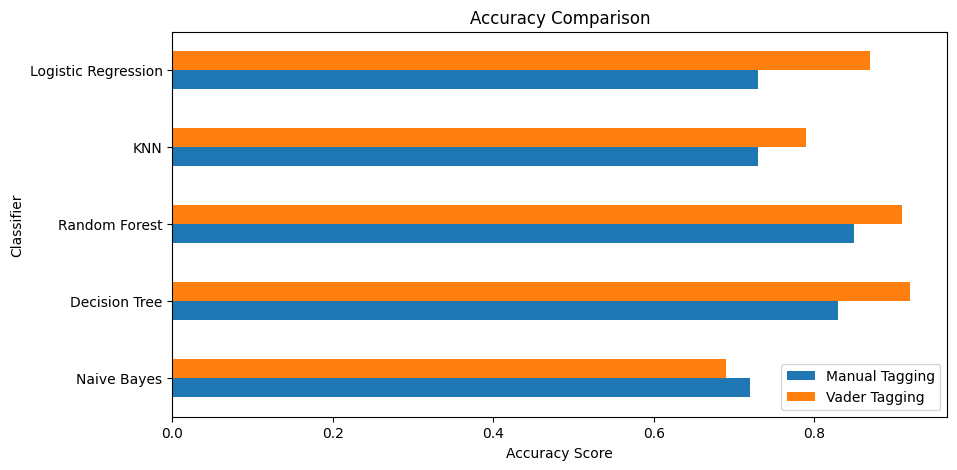

In [ ]:
# prompt: draw graph based on acc_comp dataset

acc_comp.plot(x='Classifier', kind='barh', figsize=(10,5))
plt.xlabel('Accuracy Score')
plt.ylabel('Classifier')
plt.title('Accuracy Comparison')
plt.show()
